In [1]:
#I like my cells wide and proud
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### Review the resources landscape:
```
!nvidia-smi
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
```

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from six.moves import xrange
import logging
import os
###########################
from cleverhans.attacks import CarliniWagnerL2
from cleverhans.utils import pair_visual, grid_visual, AccuracyReport
from cleverhans.utils import set_log_level
from cleverhans.utils_mnist import data_mnist
from cleverhans.utils_tf import model_train, model_eval, tf_model_load
from cleverhans_tutorials.tutorial_models import make_basic_cnn

```
def make_basic_cnn(nb_filters=64, nb_classes=10,
                   input_shape=(None, 28, 28, 1)):
    layers = [Conv2D(nb_filters, (8, 8), (2, 2), "SAME"),
              ReLU(),
              Conv2D(nb_filters * 2, (6, 6), (2, 2), "VALID"),
              ReLU(),
              Conv2D(nb_filters * 2, (5, 5), (1, 1), "VALID"),
              ReLU(),
              Flatten(),
              Linear(nb_classes),
              Softmax()]

    model = MLP(layers, input_shape)
    return model
```

In [6]:
import tensorflow as tf
print(tf.__version__)
import cleverhans
cleverhans.__version__

1.2.1


'2.0.0-8693098cd146021470b9a0179f206153'

# Initialize the parametrers as per:
https://github.com/tensorflow/cleverhans/blob/b8d15f3d7b6f820f812087512b60d9675cb431eb/cleverhans_tutorials/mnist_tutorial_cw.py

In [7]:
#     :param train_start: index of first training set example
#     :param train_end: index of last training set example
#     :param test_start: index of first test set example
#     :param test_end: index of last test set example
#     :param viz_enabled: (boolean) activate plots of adversarial examples
#     :param nb_epochs: number of epochs to train model
#     :param batch_size: size of training batches
#     :param nb_classes: number of output classes
#     :param source_samples: number of test inputs to attack
#     :param learning_rate: learning rate for training
#     :param model_path: path to the model file
#     :param targeted: should we run a targeted attack? or untargeted?
train_start=0
train_end=60000
test_start=0
test_end=10000
viz_enabled=True
nb_epochs=6
batch_size=128
nb_classes=10
source_samples=10
learning_rate=0.001
attack_iterations=100
model_path=os.path.join("models", "mnist")
targeted=True
# Object used to keep track of (and return) key accuracies
report = AccuracyReport()

# Model definition:

In [9]:
# MNIST-specific dimensions
img_rows = 28
img_cols = 28
channels = 1

# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)

# # Create TF session
# tf.device("/gpu:0")
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True

sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=.666), 
                                                 device_count={'CPU':2, 'GPU':1}))
print("Created TensorFlow session.")
set_log_level(logging.DEBUG)

# Get MNIST test data
X_train, Y_train, X_test, Y_test = data_mnist(train_start=train_start,
                                              train_end=train_end,
                                              test_start=test_start,
                                              test_end=test_end)

# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, img_rows, img_cols, channels))
y = tf.placeholder(tf.float32, shape=(None, nb_classes))

# Define TF model graph
model = make_basic_cnn()
preds = model(x)
print("Defined TensorFlow model graph.")


Created TensorFlow session.
Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)
Defined TensorFlow model graph.


###########################################################################
# Training the model using TensorFlow
###########################################################################

In [10]:
# Train an MNIST model
train_params = {
    'nb_epochs': nb_epochs,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'train_dir': os.path.join(*os.path.split(model_path)[:-1]),
    'filename': os.path.split(model_path)[-1]
}

rng = np.random.RandomState([2017, 8, 30])
# check if we've trained before, and if we have, use that pre-trained model
if os.path.exists(model_path + ".meta"):
    tf_model_load(sess, model_path)
else:
    model_train(sess, x, y, preds, X_train, Y_train, args=train_params,
                save=os.path.exists("models"), rng=rng)

# Evaluate the accuracy of the MNIST model on legitimate test examples
eval_params = {'batch_size': batch_size}
accuracy = model_eval(sess, x, y, preds, X_test, Y_test, args=eval_params)
assert X_test.shape[0] == test_end - test_start, X_test.shape
print('Test accuracy on legitimate test examples: {0}'.format(accuracy))
report.clean_train_clean_eval = accuracy

[INFO 2017-10-30 04:51:39,633 cleverhans] Epoch 0 took 2.29020690918 seconds
[INFO 2017-10-30 04:51:41,455 cleverhans] Epoch 1 took 1.81386089325 seconds
[INFO 2017-10-30 04:51:43,289 cleverhans] Epoch 2 took 1.8218960762 seconds
[INFO 2017-10-30 04:51:45,120 cleverhans] Epoch 3 took 1.81949210167 seconds
[INFO 2017-10-30 04:51:46,956 cleverhans] Epoch 4 took 1.82384395599 seconds
[INFO 2017-10-30 04:51:48,793 cleverhans] Epoch 5 took 1.82515692711 seconds
[INFO 2017-10-30 04:51:48,794 cleverhans] Completed model training.


Test accuracy on legitimate test examples: 0.9892


# Let's pick 10 legit examples to target:

Crafting 10 * 9 adversarial examples


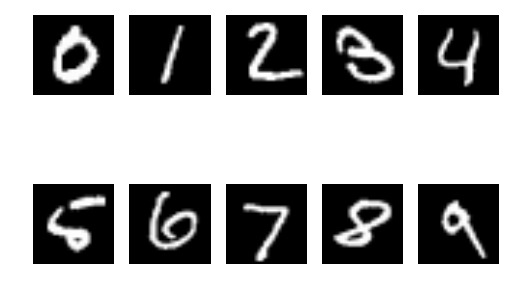

In [11]:
nb_adv_per_sample = str(nb_classes - 1)
print('Crafting ' + str(source_samples) + ' * ' + nb_adv_per_sample + ' adversarial examples')
###########################################################################

assert source_samples == nb_classes
idxs = [np.where(np.argmax(Y_test, axis=1) == i)[0][0] for i in range(nb_classes)]
# [3, 2, 1, 18, 4, 8, 11, 0, 61, 7]
# Pick the first appearances of the 9 numbers in X_test
for i,idx in enumerate(idxs):
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[idx,:,:,0],cmap='gray')
    plt.axis('off')


# Create adv samples using the Carlini-L2 attack:

In [12]:
# Form a 10 x 10 array of the inputs that you seek to target:
adv_inputs = np.array([[instance] * nb_classes for instance in X_test[idxs]],dtype=np.float32)
adv_inputs = adv_inputs.reshape((source_samples * nb_classes, img_rows, img_cols, 1))


one_hot = np.zeros((nb_classes, nb_classes))
one_hot[np.arange(nb_classes), np.arange(nb_classes)] = 1



adv_ys = np.array([one_hot] * source_samples,dtype=np.float32).reshape((source_samples * nb_classes, nb_classes))
# yname = "y_target"
# Instantiate a CW attack object
cw = CarliniWagnerL2(model, back='tf', sess=sess)
cw_params = {'binary_search_steps': 1,
             'y_target': adv_ys,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': source_samples * nb_classes if
             targeted else source_samples,
             'initial_const': 10}

adv = cw.generate_np(adv_inputs, **cw_params)

[INFO 2017-10-30 04:52:46,612 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2017-10-30 04:52:46,896 cleverhans] Running CWL2 attack on instance 0 of 100
[DEBUG 2017-10-30 04:52:46,910 cleverhans]   Binary search step 0 of 1
[DEBUG 2017-10-30 04:52:46,985 cleverhans]     Iteration 0 of 100: loss=1.78e+04 l2=0 f=-2.09
[DEBUG 2017-10-30 04:52:47,055 cleverhans]     Iteration 10 of 100: loss=8.66e+03 l2=7.15 f=-1.68
[DEBUG 2017-10-30 04:52:47,116 cleverhans]     Iteration 20 of 100: loss=3.23e+03 l2=17.5 f=-1.42
[DEBUG 2017-10-30 04:52:47,162 cleverhans]     Iteration 30 of 100: loss=2.44e+03 l2=22.2 f=-1.38
[DEBUG 2017-10-30 04:52:47,207 cleverhans]     Iteration 40 of 100: loss=2.05e+03 l2=20 f=-1.42
[DEBUG 2017-10-30 04:52:47,263 cleverhans]     Iteration 50 of 100: loss=1.72e+03 l2=17 f=-1.46
[DEBUG 2017-10-30 04:52:47,319 cleverhans]     Iteration 60 of 100: loss=1.51e+03 l2=15.1 f=-1.48
[DEBUG 2017-10-30 04:52:47,373 cleverhans]     Iteration 70 of 100: loss=1.

# Now, how good were these adv examples?

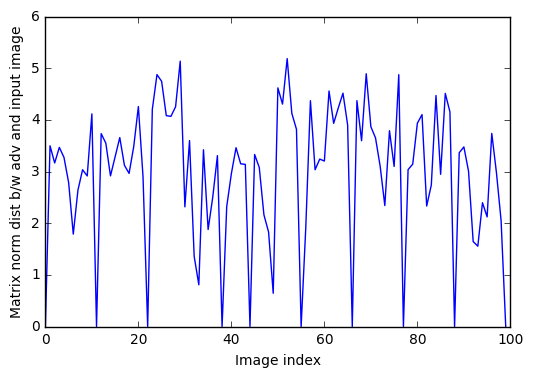

In [13]:
dev=np.zeros(100)
for i in range(100):
    dev[i]=np.linalg.norm(np.abs(adv[i,:,:,0]-adv_inputs[i,:,:,0]))
plt.plot(dev)
plt.xlabel('Image index')
plt.ylabel('Matrix norm dist b/w adv and input image')

In [14]:
eval_params = {'batch_size': np.minimum(nb_classes, source_samples)}
adv_accuracy = model_eval(sess, x, y, preds, adv, adv_ys, args=eval_params)

# Initialize our array for grid visualization
grid_shape = (nb_classes, nb_classes, img_rows, img_cols, channels)
grid_viz_data = np.zeros(grid_shape, dtype='f')

for j in range(nb_classes):
    for i in range(nb_classes):
        grid_viz_data[i, j] = adv[i * nb_classes + j]


print(grid_viz_data.shape)

print('--------------------------------------')

# Compute the number of adversarial examples that were successfully found
print('Avg. rate of successful adv. examples {0:.4f}'.format(adv_accuracy))
report.clean_train_adv_eval = 1. - adv_accuracy

# Compute the average distortion introduced by the algorithm
percent_perturbed = np.mean(np.sum((adv - adv_inputs)**2,
                                   axis=(1, 2, 3))**.5)
print('Avg. L_2 norm of perturbations {0:.4f}'.format(percent_perturbed))

# Close TF session
sess.close()

(10, 10, 28, 28, 1)
--------------------------------------
Avg. rate of successful adv. examples 1.0000
Avg. L_2 norm of perturbations 2.9940


In [15]:
report.__dict__

{'adv_train_adv_eval': 0.0,
 'adv_train_clean_eval': 0.0,
 'clean_train_adv_eval': 0.0,
 'clean_train_clean_eval': 0.98919999999999997,
 'train_adv_train_adv_eval': 0.0,
 'train_adv_train_clean_eval': 0.0,
 'train_clean_train_adv_eval': 0.0,
 'train_clean_train_clean_eval': 0.0}

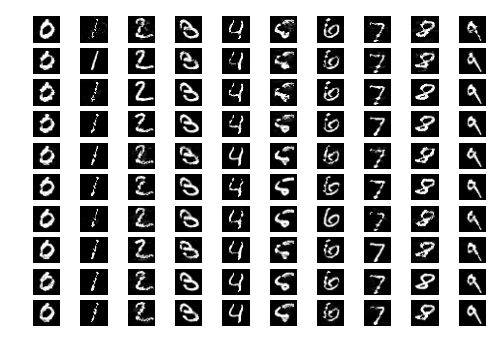

In [16]:
# Finally, block & display a grid of all the adversarial examples
_ = grid_visual(grid_viz_data)

In [17]:
# A nifty little function to visualize matrices
def plot_mat(intersection_matrix,fig_size=(15,15)):
    fig, ax = plt.subplots(figsize=fig_size)
    ax.matshow(intersection_matrix, cmap=plt.cm.Blues)
    for i in xrange(intersection_matrix.shape[1]):
        for j in xrange(intersection_matrix.shape[0]):
            c = round(intersection_matrix[j,i],2)
            ax.text(i, j, str(c), va='center', ha='center')

# Here begins the Lyapunov exponent based defense:

In [18]:
from nolds import lyap_e

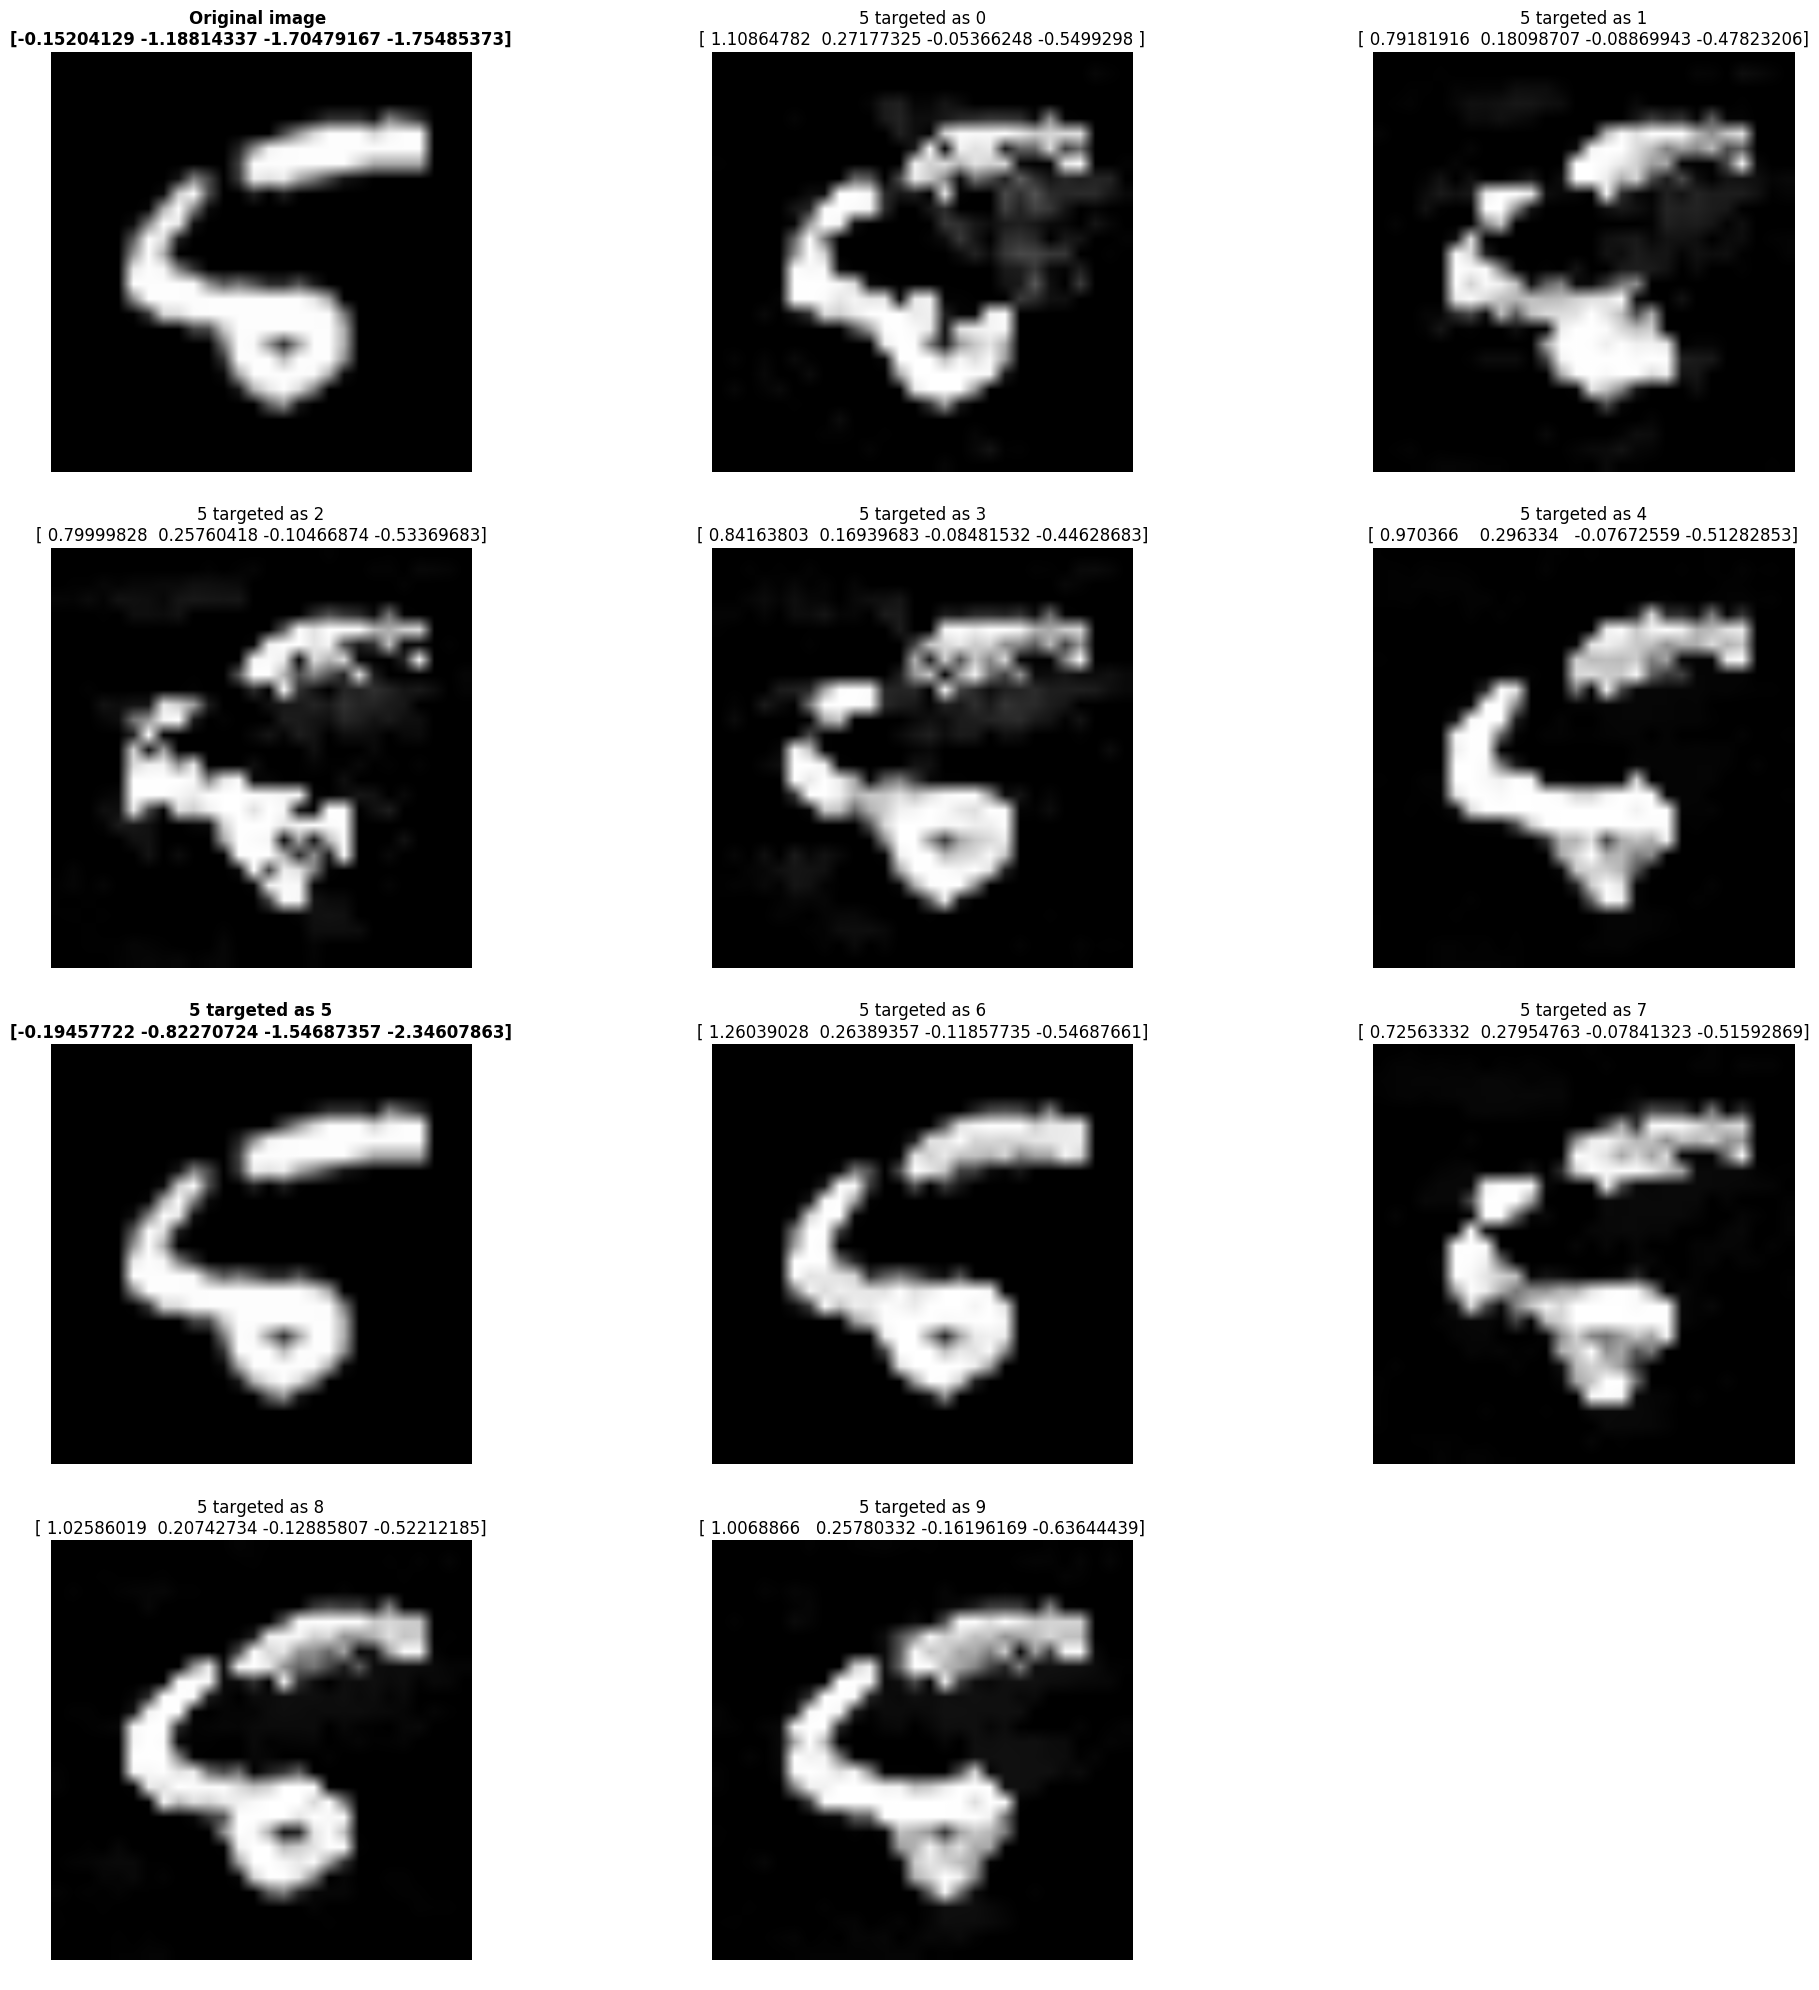

In [20]:
plt.figure(figsize=(20,20))
plt.subplot(4,3,1)
plt.imshow(X_test[idxs[5],:,:,0],cmap='gray');
plt.axis('off');
plt.title('Original image \n'+str(lyap_e(X_test[idxs[5],:,:,0].flatten())),fontweight='bold')


for i in range(10):
    plt.subplot(4,3,i+2)
    plt.imshow(grid_viz_data[5,i,:,:,0],cmap='gray')
    if(i==5):
        plt.title('5 targeted as '+str(i)+'\n'+str(lyap_e(grid_viz_data[5,i,:,:,0].flatten())),fontweight='bold')
         
         
    else:
        plt.title('5 targeted as '+str(i)+'\n'+str(lyap_e(grid_viz_data[5,i,:,:,0].flatten())))
    plt.axis('off')

plt.tight_layout()
plt.savefig('ex_5.eps')

In [21]:
from tqdm import tqdm

### Generate the lyapunov matrix for the MNIST dataset so that we can publically share this:
```
n_test=X_test.shape[0]
lya_e_test_mat=np.zeros((n_test,4))
for i in tqdm(range(n_test)):
    lya_e_test_mat[i,:]=lyap_e(X_test[i,:,:,0].flatten())
np.save('lyap_e_MNIST_test.npy',lya_e_test_mat)  
```

# Visualizing the embeddings:

In [25]:
from sklearn import manifold
from time import time
from scipy.misc import imresize

###########################################################
from matplotlib import offsetbox
#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding_2(X,y,image_display, title=None,file_name='fig.eps'):
    """
    print(X.shape,y.shape,digits.images.shape)
    ((N, 2), (N,), (N, 8, 8))
    """
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(5,5))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-11:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            img_i = imresize(image_display[i], (7, 7))
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(img_i, cmap=plt.cm.gray_r),
#                 offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.savefig(file_name)
#----------------------------------------------------------------------

# Generate the Lyapunov exponent features for the images:

100%|██████████| 100/100 [00:23<00:00,  3.98it/s]


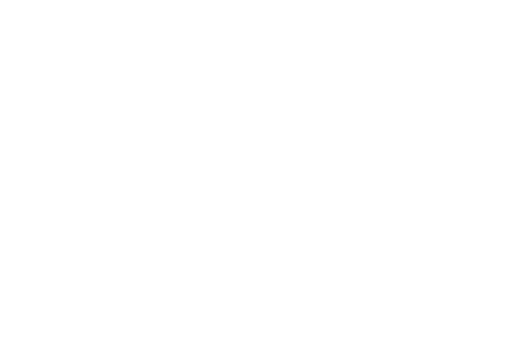

In [29]:
lyap_e_legit=np.zeros((10,4))
for i in range(10):
    lyap_e_legit[i,:]=lyap_e(X_test[idxs[i],:,:,0].flatten())
    plt.axis('off')
    
lyap_e_adv=np.zeros((100,4))
for i in tqdm(range(100)):
    lyap_e_adv[i,:]=lyap_e(adv[i,:,:,0].flatten())
    

# Unsupervised detection: Clustering
## The PCA visualization of the lyapunov exponent features:

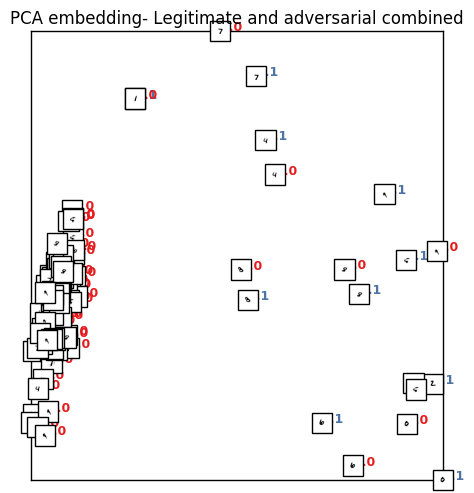

In [31]:
from sklearn import decomposition
X_lyap=np.vstack([lyap_e_legit,lyap_e_adv])
image_lyap=np.vstack([X_test[idxs,:,:,0],adv[:,:,:,0]])
y_lyap=np.zeros(110)
y_lyap[0:10]=1.1# Add the .1 just to make the label standout in the image below 


X_pca = decomposition.PCA(n_components=2).fit_transform(X_lyap)
plot_embedding_2(X_pca,y_lyap,image_lyap,
               "PCA embedding- Legitimate and adversarial combined")
# plt.savefig('pca_lyap.eps')
plt.tight_layout()
plt.show()


In [32]:
y_train=np.argmax(Y_train,axis=1)
#########
n_train=20
begin_ind=np.max(idxs)+1 # Jusdt to ensure there is no overlap
X_lyap_train=np.zeros((10*n_train,4))
X_lyap_test_pos=np.zeros((10*n_train,4))
for digit in tqdm(range(10)):
    index_digit=np.where(y_train[0:1000]==digit)[0]
    ind_digit=index_digit[index_digit>begin_ind][0:n_train]
    for i,ind in enumerate(ind_digit):
        X_lyap_train[n_train*digit+i,:]=lyap_e(X_train[ind,:,:,0].flatten())
        X_lyap_test_pos[n_train*digit+i,:]=lyap_e(X_test[ind,:,:,0].flatten())

100%|██████████| 10/10 [02:01<00:00, 12.17s/it]


In [33]:
X_lyap_test_neg=lyap_e_adv.copy()
X_lyap_test=np.vstack([X_lyap_test_pos,X_lyap_test_neg])

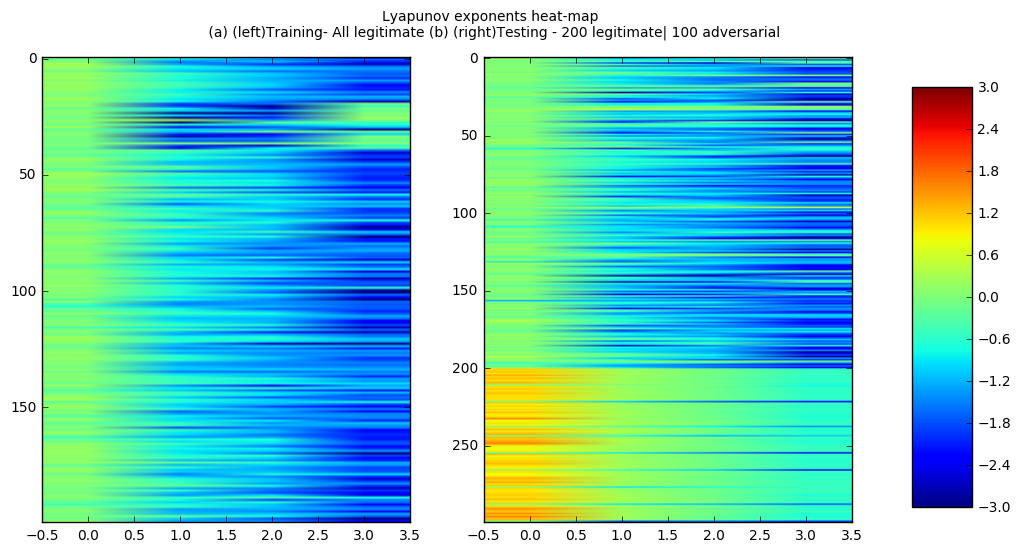

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,6))
ax=axes.flat[0]

im = ax.imshow(X_lyap_train, vmin=-3, vmax=3,aspect='auto')

ax=axes.flat[1]
im = ax.imshow(X_lyap_test, vmin=-3, vmax=3,aspect='auto')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.suptitle('Lyapunov exponents heat-map \n (a) (left)Training- All legitimate (b) (right)Testing - 200 legitimate| 100 adversarial')
plt.savefig('heatmap.eps')
plt.show()

# Supervised classification (with only positive examples)
## Using the Iso-forest outlier detector.

In [35]:
from sklearn.ensemble import IsolationForest
clf=IsolationForest(random_state=8)
clf.fit(X_lyap_train[:,0:2])
adv_detect=clf.predict(X_lyap_test[:,0:2])
y_true=np.ones(300)
y_true[200:]=-1
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true,adv_detect)

array([[ 90,  10],
       [ 33, 167]])

/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


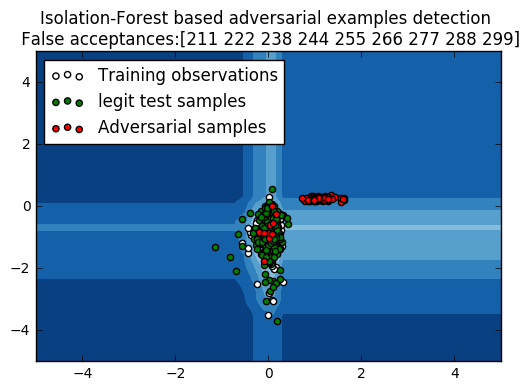

In [36]:
y_pred_train = clf.predict(X_lyap_train[:,0:2])
y_pred_test = clf.predict(X_lyap_test_pos[:,0:2])
y_pred_outliers = clf.predict(X_lyap_test_neg[:,0:2])

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

det_inlier_ind=np.where(adv_detect==1)
false_det_indices=det_inlier_ind[0][det_inlier_ind[0]>200]


plt.title('Isolation-Forest based adversarial examples detection \n False acceptances:'+str(false_det_indices))
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_lyap_train[:,0:2][:, 0], X_lyap_train[:,0:2][:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_lyap_test_pos[:,0:2][:, 0], X_lyap_test_pos[:,0:2][:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_lyap_test_neg[:,0:2][:, 0], X_lyap_test_neg[:,0:2][:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["Training observations",
            "legit test samples", "Adversarial samples"],
           loc="upper left")
plt.savefig('isoforest.eps')
plt.show()